<a href="https://colab.research.google.com/github/0x0is1/eigenface-mesh/blob/main/eigenface-mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work is based on this paper https://koreascience.kr/article/JAKO201336447761947.pdf
And further exceeded to another paper.

In [1]:
!pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.1 MB/s eta 0:00:00


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [5]:
!ls /root/.kaggle

kaggle.json


In [6]:
!kaggle datasets download olgabelitskaya/yale-face-database

 43% 5.00M/11.8M [00:00<00:00, 25.2MB/s]
100% 11.8M/11.8M [00:00<00:00, 46.2MB/s]


In [ ]:
!mkdir yale-face-database
!unzip ./yale-face-database.zip -d ./yale-face-database/

In [8]:
!rm ./yale-face-database/data/Readme.txt

In [9]:
!pip install mediapipe opencv-python-headless

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import os
from matplotlib import image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
def load_yale_face_dataset(directory, test_ratio=0.2):
    X_train_features = []
    X_test_features = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        img = mpimg.imread(img_path)
        if img is not None:
            resized_img = np.array(Image.fromarray(img).resize((100, 100)))
            flattened_img = resized_img.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_features.append(flattened_img)
                y_test_labels.append(subject_id)
            else:
                X_train_features.append(flattened_img)
                y_train_labels.append(subject_id)
    return (
        np.array(X_train_features), np.array(X_test_features),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )


In [12]:
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image

def extract_mediapipe_face(image_path):
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mp_face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = mp_face_detection.process(image_rgb)

    if results.detections:
        bbox = results.detections[0].location_data.relative_bounding_box
        h, w, _ = image.shape
        xmin = int(bbox.xmin * w)
        ymin = int(bbox.ymin * h)
        xmax = int((bbox.xmin + bbox.width) * w)
        ymax = int((bbox.ymin + bbox.height) * h)

        face_image = image[ymin:ymax, xmin:xmax]

        resized_face = cv2.resize(face_image, (100, 100))

        gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

        return gray_face

    else:
        print("No face detected in the image.")
        return None

def load_mediapipe_face_dataset(directory, test_ratio=0.2):
    X_train_features = []
    X_test_features = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        face_image = extract_mediapipe_face(img_path)

        if face_image is not None:
            flattened_img = face_image.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_features.append(flattened_img)
                y_test_labels.append(subject_id)
            else:
                X_train_features.append(flattened_img)
                y_train_labels.append(subject_id)

    return (
        np.array(X_train_features), np.array(X_test_features),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )

In [13]:
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image

def extract_mediapipe_face_landmarks(image_path):
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]

        landmark_points = []
        for landmark in face_landmarks.landmark:
            x = landmark.x * image.shape[1]
            y = landmark.y * image.shape[0]
            landmark_points.append([x, y])

        return np.array(landmark_points)

    else:
        print("No face detected in the image.")
        return None

def load_mediapipe_face_landmarks_dataset(directory, test_ratio=0.2):
    X_train_landmarks = []
    X_test_landmarks = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        landmarks = extract_mediapipe_face_landmarks(img_path)

        if landmarks is not None:
            flattened_landmarks = landmarks.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_landmarks.append(flattened_landmarks)
                y_test_labels.append(subject_id)
            else:
                X_train_landmarks.append(flattened_landmarks)
                y_train_labels.append(subject_id)

    return (
        np.array(X_train_landmarks), np.array(X_test_landmarks),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )

In [14]:
def compute_eigenfaces(X_train, n_components=10):
    if not 0 <= n_components <= min(X_train.shape):
        raise ValueError(f"Invalid value for n_components. It must be between 0 and {min(X_train.shape)}.")

    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(X_train)
    eigenfaces = pca.components_
    return eigenfaces, pca.mean_

In [15]:
def project_faces(X, eigenfaces, pca_mean):
    centered_data = X - pca_mean
    eigen_space = np.transpose(eigenfaces)
    return np.dot(centered_data, eigen_space)

In [16]:
def encrypt_face_templates(face_templates, user_key):
    cipher = AES.new(user_key, AES.MODE_ECB)
    encrypted_templates = [cipher.encrypt(template.tobytes()) for template in face_templates]
    return encrypted_templates

def decrypt_and_match(test_face_template, encrypted_templates, user_key, mode=0):
    cipher = AES.new(user_key, AES.MODE_ECB)
    decrypted_templates = [np.frombuffer(cipher.decrypt(encrypted_template), dtype=np.float64) for encrypted_template in encrypted_templates]

    if mode==1:
      fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
      for i, ax in enumerate(axes.flat):
          ax.imshow(decrypted_templates[i].reshape(12, 11), cmap='gray')
          ax.set_title(f'Decrypted Projection {i+1}')
      plt.tight_layout()
      plt.show()

    distances = [np.linalg.norm(test_face_template - template) for template in decrypted_templates]
    min_distance = min(distances)
    return np.argmin(distances), min_distance


In [17]:
dataset_directory = "./yale-face-database/data"
X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_yale_face_dataset(dataset_directory)
# X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_mediapipe_face_dataset(dataset_directory)
# X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_mediapipe_face_landmarks_dataset(dataset_directory)


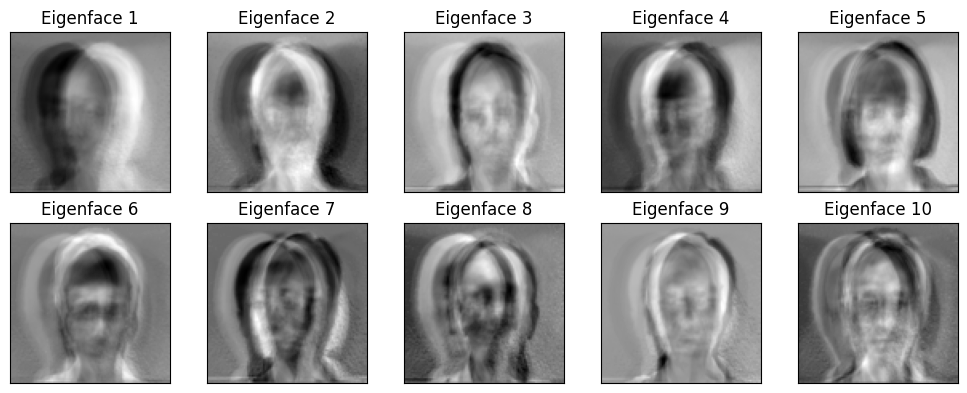

In [18]:
try:
    if len(X_train_features) > 0 and len(X_test_features) > 0:
        eigenfaces, pca_mean = compute_eigenfaces(X_train_features, n_components=132)
        fig, axes = plt.subplots(2, 5, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            ax.imshow(eigenfaces[i].reshape(100, 100), cmap='gray')
            # ax.imshow(eigenfaces[i].reshape(36, 26), cmap='gray')
            ax.set_title(f'Eigenface {i+1}')

        plt.tight_layout()
        plt.show()
except Exception as e:
    print(e)


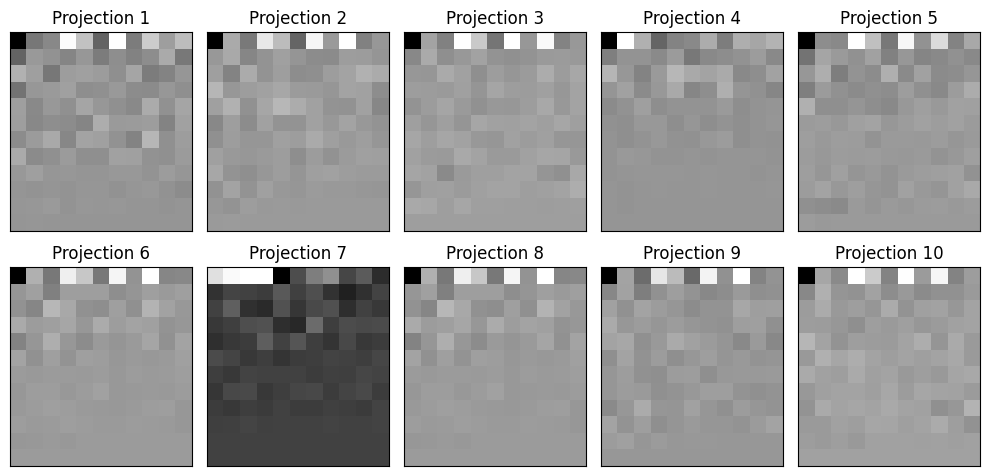

In [19]:
projected_train_faces = project_faces(X_train_features, eigenfaces, pca_mean)
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(projected_train_faces[i].reshape(12, 11), cmap='gray')
    ax.set_title(f'Projection {i+1}')

plt.tight_layout()
plt.show()

In [20]:
user_key = get_random_bytes(16)
encrypted_train_templates = encrypt_face_templates(projected_train_faces, user_key)
for i, j in enumerate(encrypted_train_templates[:11]):
  print(f'AES encrypted face template {i}: {j[:20]}...')

AES encrypted face template 0: b'\x84$.\xec\x892XSco\x9a3p=1\xcb\x87y\x9f\x9b'...
AES encrypted face template 1: b'\xab\xc1nv\x83l\xe8@H\xac\xfa\n-\xa5K\xbf:\xf5He'...
AES encrypted face template 2: b'\xa3\x9bL\x06\xfeI\xac\xdf\xa8\x13\xac\\\xe8\xc3R\x15\xbf]\x17\xe8'...
AES encrypted face template 3: b'\xb6\xff\xe9\xf0>i\x1e*\xbc\x97\x8c\xfb\xf5[\x1d\x84\xb9wm8'...
AES encrypted face template 4: b'\xd6\xfb\x87\xd7i\x15\xd1I\x8e\xf3\x9f\x92\x03\x9a\xf4\xd1f\xcb\xf2\xbc'...
AES encrypted face template 5: b'f\xe4\x0f,\xc3G\x1e\xcc\xc7\xc7\xc4\xb9 \xeb\x83\x90"\x10\x85\x0f'...
AES encrypted face template 6: b'?\xca%\x1c?\xb8\x13\xef\xe4Mcw^%\xc1lg\xfe\xd0+'...
AES encrypted face template 7: b'f\xe4\x0f,\xc3G\x1e\xcc\xc7\xc7\xc4\xb9 \xeb\x83\x90"\x10\x85\x0f'...
AES encrypted face template 8: b"2VN\x15\xcdA\xc1\xf1\x98('\xfd\xbfg\x122\xfburc"...
AES encrypted face template 9: b'?\xcc\xe2\x0f\x7f\x10\x04\xbaN\xfb\x0b\xe0\x1a\xa7xt\xa2R_i'...
AES encrypted face template 10: b'\xcb\x07\xd8\x9

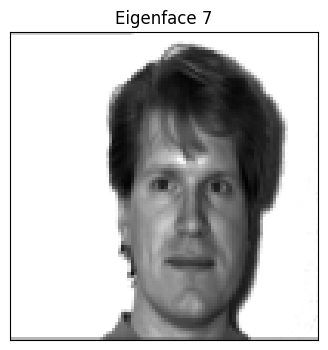

In [21]:
# Test feature 1 projection
fig, ax = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
# ax.imshow(X_test_features[0].reshape(36, 26), cmap='gray')
ax.imshow(X_test_features[0].reshape(100, 100), cmap='gray')
ax.set_title('Eigenface 7')
plt.show()

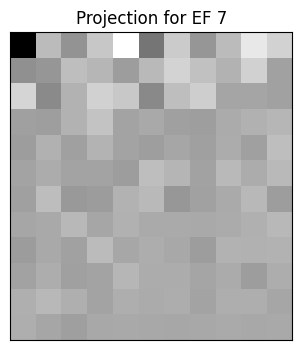

In [22]:
# Projection of test feature 1
projected_test_face = np.dot(X_test_features[0] - pca_mean, eigenfaces.T)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(projected_test_face.reshape(12, 11), cmap='gray')
ax.set_title('Projection for EF 7')
plt.show()

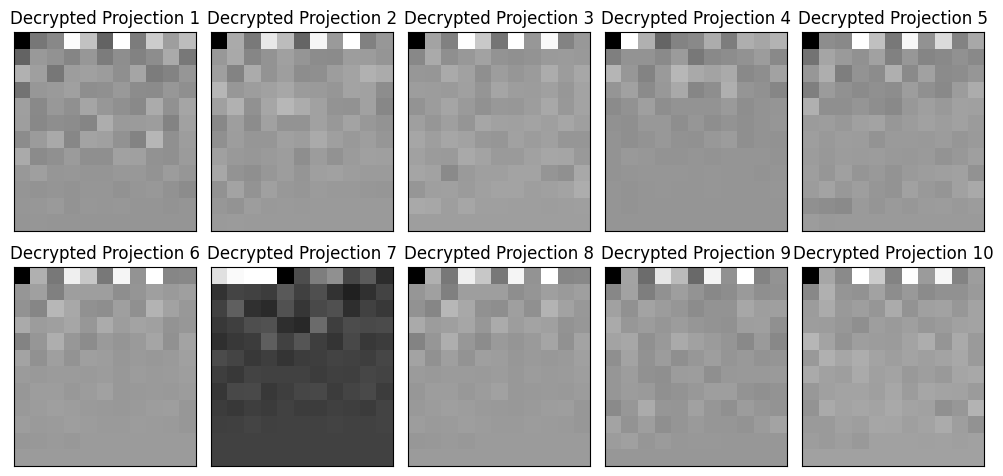

Subject: subject07, min-threshold: 3779.991557806185


In [23]:
test_features = X_test_features[0]

projected_test_face = np.dot(test_features - pca_mean, eigenfaces.T)

match_result, threshold = decrypt_and_match(projected_test_face, encrypted_train_templates, user_key, 1)
matched_label = subject_names[int(match_result/11)+1]
print(f"Subject: {matched_label}, min-threshold: {threshold}")

In [24]:
ot = 0
for test_features in X_test_features:
    projected_test_face = np.dot(test_features - pca_mean, eigenfaces.T)
    match_result, threshold = decrypt_and_match(projected_test_face, encrypted_train_templates, user_key)
    matched_label = subject_names[int(match_result/11)+1]
    ot += threshold
    print(f"Subject: {matched_label}, min-threshold: {threshold}")
print(f"Average Threshold : {ot/len(X_test_features)}")

Subject: subject07, min-threshold: 3779.991557806185
Subject: subject07, min-threshold: 4681.867835285371
Subject: subject07, min-threshold: 4776.825503136871
Subject: subject07, min-threshold: 3720.8216146779855
Subject: subject09, min-threshold: 3756.041029292276
Subject: subject09, min-threshold: 4772.776311880466
Subject: subject01, min-threshold: 2524.650274032959
Subject: subject07, min-threshold: 4605.122050137163
Subject: subject09, min-threshold: 4469.967628894926
Subject: subject09, min-threshold: 4230.562997398667
Subject: subject09, min-threshold: 4117.034259433318
Subject: subject09, min-threshold: 4414.745799356122
Subject: subject01, min-threshold: 3987.654735168195
Subject: subject09, min-threshold: 4118.866530404766
Subject: subject09, min-threshold: 3475.8753488626676
Subject: subject09, min-threshold: 3899.7620005821077
Subject: subject09, min-threshold: 3899.7620005821077
Subject: subject09, min-threshold: 6146.066608411156
Subject: subject09, min-threshold: 3688.03